In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from IPython.display import display
from collections import defaultdict

## Training Loss over training epoches

In [14]:
def plot_loss_over_time(tsvf, output_path):
    df = pd.read_csv(tsvf, sep='\t')

    # Plot train_loss and val_loss
    plt.figure(figsize=(10, 6))
    plt.plot(df['epoch'], df['train_loss'], label='Train Normalized MSE')
    plt.plot(df['epoch'], df['val_loss'], label='Validation Normalized MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path)

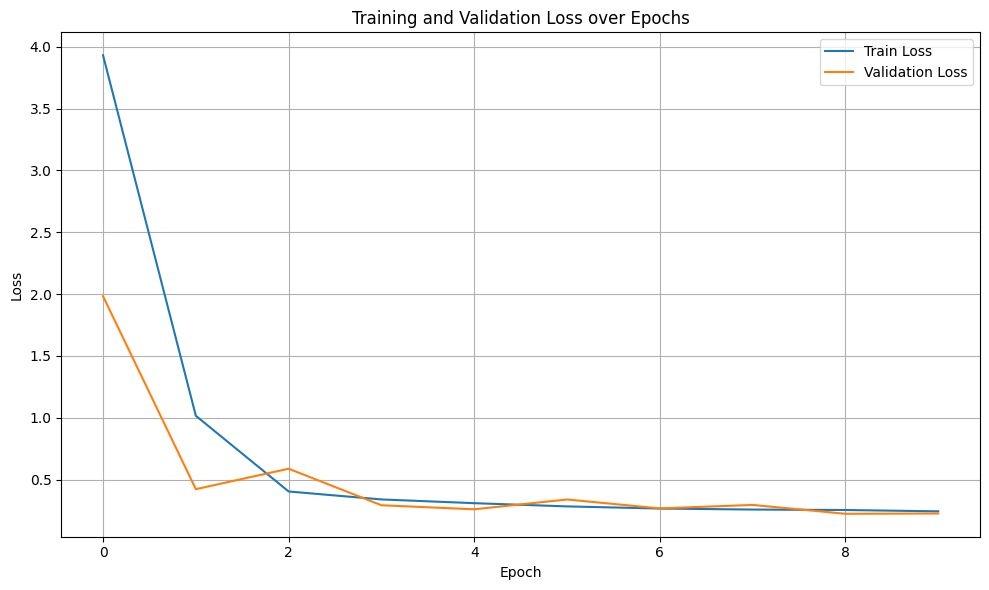

In [15]:
plot_loss_over_time('/home/zhaoyang-new/School_Work/cse251b_project/model_outs/GS_LSTM_2048_part1/lr0.001_beta10.8_weight_decay0.0_beta20.999/training_epoches.tsv', 'loss_plot_test.png')

In [2]:
train_file = np.load('../source/src_data/train.npz')
train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../source/src_data/test_input.npz')
test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


In [10]:
obj_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
obj_mapping = {idx: obj for idx, obj in enumerate(obj_types)}

# Assign each object type a distinct color
type_colors = {
    'vehicle': 'blue',
    'pedestrian': 'red',
    'motorcyclist': 'cyan',
    'cyclist': 'pink',
    'bus': 'brown',
    'static': 'gray',
    'background': 'black',
    'construction': 'yellow',
    'riderless_bicycle': 'pink',
    'unknown': 'magenta'
}

def make_gif(data_matrix, name='example'):
    fig, ax = plt.subplots(figsize=(10, 10))

    def update(frame):
        ax.clear()

        # Plot non-ego agents
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]
                ys = data_matrix[i, :frame+1, 1]
                mask = (xs != 0) & (ys != 0)
                xs = xs[mask]
                ys = ys[mask]

                if len(xs) > 0 and len(ys) > 0:
                    type_idx = int(data_matrix[i, 0, 5])
                    obj_type = obj_mapping.get(type_idx, 'unknown')
                    color = type_colors.get(obj_type, 'black')
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)

        # Plot ego agent
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1], color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1], s=80, color='tab:orange')

        ego_obj = obj_mapping[int(data_matrix[0, 0, 5])]
        ax.set_title(f'Timestep {frame} ({ego_obj})')

        # Axis limits
        ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                    data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                    data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
        ax.legend()

        return ax.collections + ax.lines

    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()


In [11]:
for k in range(0, 1):
    data_matrix = train_data[k]
    make_gif(data_matrix, f'index{k}')

In [12]:
import matplotlib.pyplot as plt

obj_types = ['vehicle', 'pedestrian', 'motorcyclist', 'cyclist', 'bus', 'static', 'background', 'construction', 'riderless_bicycle', 'unknown']
obj_mapping = {idx: obj for idx, obj in enumerate(obj_types)}
type_colors = {
    'vehicle': 'blue',
    'pedestrian': 'green',
    'motorcyclist': 'purple',
    'cyclist': 'red',
    'bus': 'brown',
    'static': 'gray',
    'background': 'black',
    'construction': 'pink',
    'riderless_bicycle': 'cyan',
    'unknown': 'magenta'
}

def make_scene_png(data_matrix, name='example', frame=None):
    if frame is None:
        frame = data_matrix.shape[1] - 1  # default to final frame

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot other agents
    for i in range(1, data_matrix.shape[0]):
        xs = data_matrix[i, :frame + 1, 0]
        ys = data_matrix[i, :frame + 1, 1]
        mask = (xs != 0) & (ys != 0)
        xs = xs[mask]
        ys = ys[mask]

        if len(xs) > 0:
            type_idx = int(data_matrix[i, 0, 5])
            obj_type = obj_mapping.get(type_idx, 'unknown')
            color = type_colors.get(obj_type, 'black')
            ax.plot(xs, ys, alpha=0.9, color=color)
            ax.scatter(xs[-1], ys[-1], s=80, color=color)  # latest position

    # Plot ego agent
    ego_xs = data_matrix[0, :frame + 1, 0]
    ego_ys = data_matrix[0, :frame + 1, 1]
    ego_mask = (ego_xs != 0) & (ego_ys != 0)
    ego_xs = ego_xs[ego_mask]
    ego_ys = ego_ys[ego_mask]
    ax.plot(ego_xs, ego_ys, color='tab:orange', label='Ego Vehicle')
    ax.scatter(ego_xs[-1], ego_ys[-1], s=80, color='tab:orange')

    ego_obj = obj_mapping[int(data_matrix[0, 0, 5])]
    ax.set_title(f'Final Scene (Frame {frame}) – Ego: {ego_obj}')
    ax.set_xlim(data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].min() - 10,
                data_matrix[:, :, 0][data_matrix[:, :, 0] != 0].max() + 10)
    ax.set_ylim(data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].min() - 10,
                data_matrix[:, :, 1][data_matrix[:, :, 1] != 0].max() + 10)
    ax.legend()
    plt.savefig(f'trajectory_visualization_{name}.png')
    plt.close()


In [13]:
for k in range(0, 1):
    data_matrix = train_data[k]
    make_scene_png(data_matrix, f'index{k}')